In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))


import Models.linear_model 
from Filters.linear_kalman  import LinearKalmanFilter
from Filters.ukf  import UnscentedKalmanFilter
from Filters.particle import ParticleFilter

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
np.random.seed(123)

d = 2   # dimensión estado
m = 1   # dimensión observación
T = 50

A = np.array([[1.0, 0.1],
              [0.0, 1.0]])

H = np.array([[1.0, 0.0]])

Sigma = 0.01 * np.eye(d)
Gamma = 0.1 * np.eye(m)


In [4]:
def simulate_lgssm(A, H, Sigma, Gamma, x0, T):
    d = len(x0)
    m = H.shape[0]

    X = np.zeros((T + 1, d))
    Y = np.zeros((T, m))

    X[0] = x0
    for t in range(T):
        X[t + 1] = A @ X[t] + np.random.multivariate_normal(np.zeros(d), Sigma)
        Y[t] = H @ X[t + 1] + np.random.multivariate_normal(np.zeros(m), Gamma)

    return X, Y

x0 = np.array([0.0, 1.0])
X_true, Y = simulate_lgssm(A, H, Sigma, Gamma, x0, T)


In [5]:

def A_fn(theta): return A
def H_fn(theta): return H
def Sigma_fn(theta): return Sigma
def Gamma_fn(theta): return Gamma

def Phi(x, theta):
    return A @ x

def h(x, theta):
    return H @ x

def prior_logpdf(theta):
    return 0.0  # fijo para benchmarking

m0 = np.zeros(d)
P0 = np.eye(d)
theta = None


In [6]:
t0 = time.time()

kf = LinearKalmanFilter(
    theta, m0, P0, prior_logpdf,
    A_fn, H_fn, Sigma_fn, Gamma_fn
)


kf_res = kf.filter(Y)
kf_time = time.time() - t0


In [7]:
kf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.205759990302337),
 'log_posterior': np.float64(-29.205759990302337),
 'prediction': (array([7.64087785, 2.22346979]),
  array([[0.03316331, 0.025858  ],
         [0.025858  , 0.1282876 ]]))}

In [8]:


t0 = time.time()

ukf = UnscentedKalmanFilter(
    theta, m0, P0, prior_logpdf,
    Phi, h, Sigma_fn, Gamma_fn
)

ukf_res = ukf.filter(Y)

ukf_time = time.time() - t0

In [9]:
ukf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.20576322913742),
 'log_posterior': np.float64(-29.20576322913742),
 'prediction': (array([7.64087778, 2.22346973]),
  array([[0.03316329, 0.02585799],
         [0.02585799, 0.12828748]]))}

In [10]:
t0 = time.time()

pf = ParticleFilter(
    theta, N=100000,
    m0=m0, P0=P0,
    prior_logpdf=prior_logpdf,
    Phi=Phi, h=h,
    Sigma_fn=Sigma_fn,
    Gamma_fn=Gamma_fn
)

pf_res = pf.filter(Y)

pf_time = time.time() - t0

In [11]:
pf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.31459745845057),
 'log_posterior': np.float64(-29.31459745845057),
 'prediction': (array([7.63881469, 2.22079661]),
  array([[0.03311283, 0.0262315 ],
         [0.0262315 , 0.13031269]])),
 'particles': array([[6.99380097, 1.15627244],
        [7.41742918, 1.56285262],
        [7.15704367, 2.04063058],
        ...,
        [8.24953558, 2.49046057],
        [7.66644189, 2.68223172],
        [7.70824959, 2.83749222]], shape=(100000, 2)),
 'weights': array([7.86723362e-08, 1.24181146e-05, 3.86628233e-07, ...,
        2.37836974e-06, 2.67455940e-05, 2.61639307e-05], shape=(100000,))}

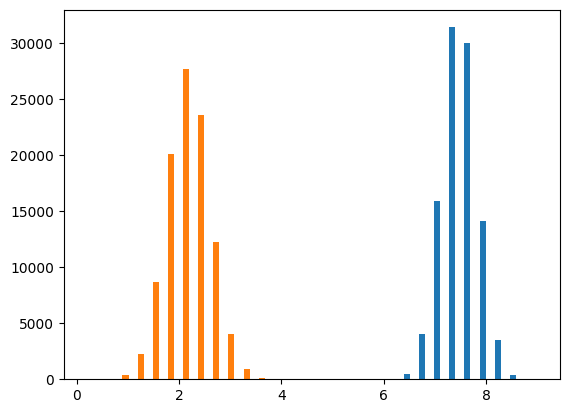

In [20]:
plt.hist(pf_res['particles'],bins=30)
plt.show()

In [12]:
def rmse(x_hat, x_true):
    return np.sqrt(np.mean((x_hat - x_true)**2))

kf_rmse = rmse(kf_res["prediction"][0], X_true[-1])
ukf_rmse = rmse(ukf_res["prediction"][0], X_true[-1])
pf_rmse = rmse(pf_res["prediction"][0], X_true[-1])

kf_ll = kf_res["log_likelihood"]
ukf_ll = ukf_res["log_likelihood"]
pf_ll = pf_res["log_likelihood"]

print("\n=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===\n")

print(f"KF  | RMSE: {kf_rmse:.5f} | logL: {kf_ll:.5f} | time: {kf_time:.3f}s")
print(f"UKF | RMSE: {ukf_rmse:.5f} | logL: {ukf_ll:.5f} | time: {ukf_time:.3f}s")
print(f"PF  | RMSE: {pf_rmse:.5f} | logL: {pf_ll:.5f} | time: {pf_time:.3f}s")



=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===

KF  | RMSE: 0.15312 | logL: -29.20576 | time: 0.005s
UKF | RMSE: 0.15312 | logL: -29.20576 | time: 0.025s
PF  | RMSE: 0.15192 | logL: -29.31460 | time: 226.544s
